In [1]:
import sys, os
import pathlib
import torch
import numpy as np
import tqdm
import networkx as nx
from matplotlib import pyplot as plt

In [2]:
import dgl
from dgl.data import register_data_args, load_data

In [3]:
reddit = dgl.data.RedditDataset()

Finished data loading.
  NumNodes: 232965
  NumEdges: 114615892
  NumFeats: 602
  NumClasses: 41
  NumTrainingSamples: 153431
  NumValidationSamples: 23831
  NumTestSamples: 55703


In [14]:
cora = dgl.data.CoraDataset()

In [4]:
def statistics_of_subgraph(g:nx.Graph):
    return {
        'is_connected':nx.is_connected(g),
        'number_connected_components': nx.number_connected_components(g)
    }
    pass

In [5]:
dataset = reddit

In [9]:
id=20
label_nodes = np.where(dataset.labels==id)[0]
print(len(label_nodes), label_nodes[:10])

1596 [ 124  427  548  826  865  886  895 1526 1950 1981]


In [10]:
sg = dataset.graph.subgraph(label_nodes)
sg

DGLGraph(num_nodes=1596, num_edges=696284,
         ndata_schemes={}
         edata_schemes={})

In [ ]:
if type(sg) not in (nx.Graph, nx.DiGraph):
    nx_label_sg = sg.to_networkx().to_undirected()
    print('nx_label_sg done')
    nx_graph = dataset.graph.to_networkx().to_undirected()
    print('nx_graph done')
else:
    nx_label_sg = sg.to_undirected()
    nx_graph = dataset.graph.to_undirected()

statistics_of_subgraph(nx_label_sg)

In [20]:
subgraph_cc = sorted(nx.connected_components(nx_label_sg), key=len, reverse=True)
# nx.connected_components(nx_label_sg)
print(
[len(cc) for cc in subgraph_cc][:10],
    subgraph_cc[0].__len__() / len(label_nodes)
)
subgraph_cc[1:5]

[287, 8, 6, 4, 4, 3, 3, 2, 2, 2] 0.8176638176638177


[{1853, 1861, 2005, 2141, 2320, 2345, 2418, 2511},
 {424, 571, 1762, 2331, 2495, 2694},
 {903, 1390, 1491, 1605},
 {1050, 1306, 1310, 1492}]

In [23]:
info = statistics(nx_graph, [1853,424], level=6)
colors = get_colors(len(dataset.labels), mode='raw')


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

Node   1-hop   2-hop   3-hop   4-hop   5-hop   6-hop
1853   2       1       4       3       6       10   
424    1       5       2       42      96      493  


In [46]:
case = 1853
hop = 6
sub_node = sum([node_list for node_list in info[case][0][:hop]], [])
sub_graph = nx_graph.subgraph(sub_node)
colors = get_colors(len(dataset.labels), mode='raw')
pos = nx.spring_layout(sub_graph, k=0.15)
class_node_pos = get_node_pos(dataset.labels, sub_node, mode='raw')
labels = dict(zip(sub_node, dataset.labels[sub_node]))
labels.update({case: f'{case}:{dataset.labels[case]}'})

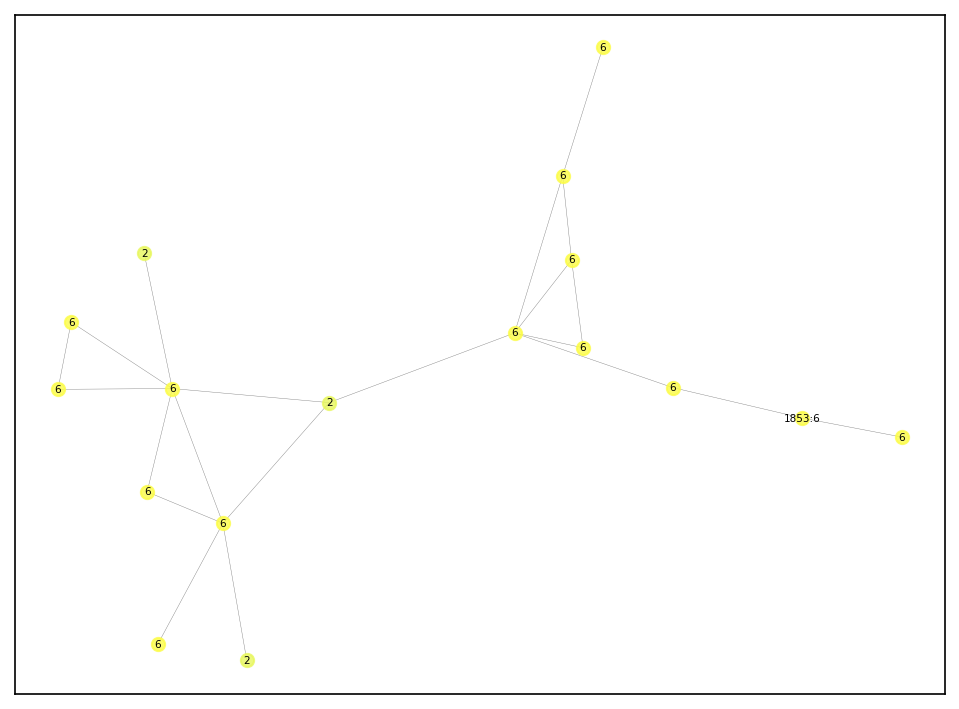

In [47]:
plot_cluster(sub_graph, class_node_pos, colors, pos, labels=labels)

In [159]:
sub_graph.number_of_edges()

48

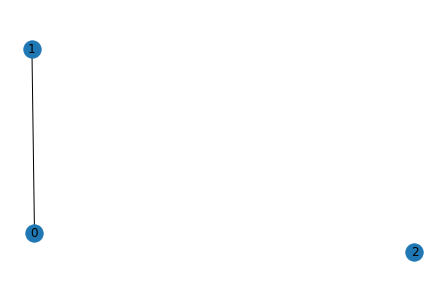

In [33]:
G = dgl.DGLGraph()
G.add_nodes(5)
G.add_edges([0, 1, 2, 3, 4], [1, 2, 3, 4, 0])
SG = G.subgraph([0,1,3])
nx_SG = SG.to_networkx().to_undirected()
nx.draw(nx_SG, with_labels=True)


In [35]:
nx.is_connected(G.to_networkx().to_undirected())

True

In [ ]:
nx_reddit = reddit.graph.to_networkx().to_undirected()

In [45]:
list(nx_reddit.neighbors(1)).__len__()

154

In [52]:
nx_reddit = nx_reddit.to_undirected()

In [58]:
degree = nx_reddit.degree

In [67]:
np.mean(list(dict(degree).values()))

In [75]:
reddit.train_mask.nonzero()

(array([     1,      3,      4, ..., 232961, 232962, 232963]),)

In [86]:
(reddit.labels[1] == reddit.labels[list(nx_reddit.neighbors(1))]).mean()

0.974025974025974

In [111]:
def neighbor_same_label_dglgraph(graph: dgl.DGLGraph, train_mask: np.array, labels: np.array):
    train_nodes = np.nonzero(train_mask)[0]
    same_label_neib_percentage = {}
    for node in tqdm(train_nodes):
        neibs = list(graph.successors(node))
        same_label_neib_percentage[node] = ((labels[node]==labels[neibs]).mean(), len(neibs))
    return same_label_neib_percentage



In [25]:
from tqdm import tqdm
percent = neighbor_same_label_dglgraph(graph, reddit.train_mask, reddit.labels)

100%|██████████| 153431/153431 [05:06<00:00, 500.15it/s]


In [26]:
from operator import itemgetter
value = np.array(list((percent.values())))

In [31]:
value[:,0].min()

0.0

In [100]:
labels = reddit.labels
node = 1
neibs = nx_reddit.neighbors(node)

(labels[node]==labels[neibs]).mean()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [39]:
import tensorflow as tf
import numpy as np
import time
import json
from tensorflow import gfile
from networkx.readwrite import json_graph

dataset_path, dataset_str = '/yushi/dataset/', 'Amazon2M'

"""Load GraphSAGE data."""
start_time = time.time()

graph_json = json.load(
  gfile.Open('{}/{}/{}-G.json'.format(dataset_path, dataset_str,
                                      dataset_str)))
graph_nx = json_graph.node_link_graph(graph_json)

id_map = json.load(
  gfile.Open('{}/{}/{}-id_map.json'.format(dataset_path, dataset_str,
                                           dataset_str)))
is_digit = list(id_map.keys())[0].isdigit()
id_map = {(int(k) if is_digit else k): int(v) for k, v in id_map.items()}
class_map = json.load(
  gfile.Open('{}/{}/{}-class_map.json'.format(dataset_path, dataset_str,
                                              dataset_str)))

is_instance = isinstance(list(class_map.values())[0], list)
class_map = {(int(k) if is_digit else k): (v if is_instance else int(v))
           for k, v in class_map.items()}

broken_count = 0
to_remove = []
for node in graph_nx.nodes():
    if node not in id_map:
        to_remove.append(node)
        broken_count += 1
for node in to_remove:
    graph_nx.remove_node(node)
tf.logging.info(
  'Removed %d nodes that lacked proper annotations due to networkx versioning issues',
  broken_count)

INFO:tensorflow:Removed 0 nodes that lacked proper annotations due to networkx versioning issues


In [48]:
feats = np.load(
  gfile.Open(
      '{}/{}/{}-feats.npy'.format(dataset_path, dataset_str, dataset_str),
      'rb')).astype(np.float32)

In [50]:
val_data = np.array(
  [id_map[n] for n in graph_nx.nodes() if graph_nx.nodes[n]['val']],
  dtype=np.int32)
test_data = np.array(
  [id_map[n] for n in graph_nx.nodes() if graph_nx.nodes[n]['test']],
  dtype=np.int32)

In [77]:
# Process labels
if isinstance(list(class_map.values())[0], list):
    num_classes = len(list(class_map.values())[0])
    labels = np.zeros((num_data, num_classes), dtype=np.float32)
    for k in class_map.keys():
        labels[id_map[k], :] = np.array(class_map[k])
else:
    num_classes = len(set(class_map.values()))
    labels = np.zeros((num_data, num_classes), dtype=np.float32)
for k in class_map.keys():
    labels[id_map[k], class_map[k]] = 1

In [53]:
test_data.shape

In [58]:
edges = []
for edge in graph_nx.edges():
    if edge[0] in id_map and edge[1] in id_map:
        edges.append((id_map[edge[0]], id_map[edge[1]]))
num_data = len(id_map)

In [59]:
is_train = np.ones((num_data), dtype=np.bool)
is_train[val_data] = False
is_train[test_data] = False
train_data = np.array([n for n in range(num_data) if is_train[n]],dtype=np.int32)

In [62]:
train_data[-10:]

array([1709987, 1709988, 1709989, 1709990, 1709991, 1709992, 1709993,
       1709994, 1709995, 1709996], dtype=int32)

In [67]:
np.max(tuple(graph_nx.degree).values())

AttributeError: 'tuple' object has no attribute 'values'

In [69]:
amazon_graph_degree = dict(graph_nx.degree)

In [102]:
train_mask = np.zeros((num_data))

array([0., 0., 0., ..., 0., 0., 0.])

In [73]:
def graph_degree(graph: nx.Graph):
    '''
    @param graph: networkx graph
    '''
    if type(graph) is nx.DiGraph:
        graph = graph.to_undirected()    
    degree = dict(graph.degree)
    return {
        'max_deg': max(degree.values()),
        'avg_deg': np.mean(tuple(degree.values())),
        'min_deg': min(degree.values())
    }

In [74]:
graph_degree(graph_nx)

{'max_deg': 17481, 'avg_deg': 50.517278480573324, 'min_deg': 0}

In [ ]:
neighbor_same_label_nxgraph()

In [104]:
logit_label = np.where(labels)

In [105]:
logit_label[0]

array([      0,       1,       2, ..., 2449026, 2449027, 2449028])

In [106]:
train_mask[logit_label[0]] = 1

In [110]:
train_mask.sum()

In [118]:
def neighbor_same_label_nxgraph(graph: nx.Graph, train_mask: np.array, labels: np.array):
    """!
    :param graph: networkx graph
    """
    train_nodes = np.nonzero(train_mask)[0]
    same_label_neib_percentage = {}
    for node in tqdm(train_nodes):
        neibs = list(graph.neighbors(node))
#         print(neibs)
        same_label_neib_percentage[node] = ((labels[node]==labels[neibs]).mean(), len(neibs))
    return same_label_neib_percentage

In [1]:
# percent = neighbor_same_label_nxgraph(graph_nx, train_mask, logit_label[1])

In [116]:
logit_label

(array([      0,       1,       2, ..., 2449026, 2449027, 2449028]),
 array([ 0,  1,  2, ...,  3, 18,  3]))

In [120]:
value = np.array(list((percent.values())))

In [132]:
np.nanmax( value[:,0])

1.0

In [11]:
def bfs_queue(graph: nx.Graph, root, max_level=3, level=0):
    import collections
    queue, res = collections.deque([(root, 0)]), []
    nodes = set(res)
    while queue:
        node, level = queue.popleft()
        if level > max_level:
            break
        if node not in nodes:
            nodes.update([node])
            if len(res) < level+1:
                res.insert(level, [])
            res[level].append(node)
        for neighbor in list(graph[node]):
            try:
                if neighbor not in sum(res,[]):
                    queue.append([neighbor, level+1])
            except:
                import pdb; pdb.set_trace()
    return res, list(nodes)

def statistics(graph, nodes, level=6):
    from texttable import Texttable
    from tqdm import tqdm
    table = Texttable()
    table.set_deco(Texttable.HEADER)
    results = {}
#     table.set_cols_dtype(['t',  # text
#                               'f',  # float (decimal)
#                               'e',  # float (exponent)
#                               'i',  # integer
#                               'a']) # automatic
    stat = [['Node']]
    stat[0].extend([f'{i}-hop' for i in range(1,level+1)])
    for node in tqdm(nodes):
        res, nodes = bfs_queue(graph, node, level)
        row = [node]
        for hop in range(1, level+1):
            if len(res) < hop+1:
                row.append(0)
            else:
                row.append(len(res[hop]))
        stat.append(row)
        results[node] = (res, nodes)
    table.add_rows(stat)
    print(table.draw())
    return results  
def get_colors(label_number: int, mode: str):
    import randomcolor
    rand_color = randomcolor.RandomColor()
    if mode == 'diff':
        colors = {'train': 'grey', 'pred_train': 'green', 'pred_false': 'r'}
    elif mode == 'raw':
        colors = dict([(i, j) for i, j in enumerate(
            rand_color.generate(count=label_number))])
    elif mode == 'train_test':
        colors = {'train': 'grey', 'test': 'black'}
    elif mode == 'error':
        colors = dict([(i, j) for i, j in enumerate(
            rand_color.generate(count=label_number))])
        colors.update({'root': 'black'})
    else:
        raise NotImplementedError
    return colors

from typing import Dict, Tuple, List, Sequence, Optional
def get_node_pos(labels: Optional[np.ndarray] = None, sg_nodes: List = None, idx_test: Optional[List] = None, mode='raw', predict: Optional[np.ndarray] = None) -> Dict:
    '''
    1. get the whole graph: raw
    2. train and test node
    3. right and wrong node
    '''
    if type(labels) is torch.Tensor:
        labels = labels.cpu().numpy()
    if type(predict) is torch.Tensor:
        predict = predict.cpu().numpy()

    node_pos = {}
    # np.argwhere(labels == label).flatten().tolist()})
    if mode == 'raw':
        if sg_nodes is not None:
            for label in set(labels[sg_nodes]):
                node_pos.update(
                    {label: [node for node in sg_nodes if labels[node] == label]})
        else:
            for label in set(labels):
                node_pos.update(
                    {label: np.argwhere(labels == label).flatten().tolist()})
    elif mode == 'error':
        root = sg_nodes[0]
        for label in set(labels[sg_nodes]):
            node_pos.update(
                {label: [node for node in sg_nodes if labels[node] == label]})
        print(node_pos)
        node_pos.update({'root': [root]})
                            
    elif mode == 'train_test':
        assert idx_test is not None and sg_nodes is not None
        test_sg_nodes = list(set(sg_nodes).intersection(idx_test))
        train_sg_nodes = list(set(sg_nodes).difference(test_sg_nodes))
        node_pos.update({'train': train_sg_nodes, 'test': test_sg_nodes})
        pass

    elif mode == 'diff':
        assert predict is not None and sg_nodes is not None and idx_test is not None
        test_sg_nodes = list(set(sg_nodes).intersection(idx_test))
        train_sg_nodes = list(set(sg_nodes).difference(test_sg_nodes))
        true = list(set(idx_test[np.argwhere(
            labels[idx_test] == predict).flatten().tolist()]).intersection(test_sg_nodes))
        false = list(set(test_sg_nodes).difference(true))
        node_pos.update(
            {'train': train_sg_nodes, 'pred_true': true, 'pred_false': false})

    else:
        raise NotImplementedError(f'mode: {mode} unrecognized')

    return node_pos

def plot_cluster(graph, node_pos, colors, pos, options={"node_size": 40, "alpha": 0.8},  figsize=(8, 6), spring_k=0.15, labels=None, border_edge_list=None):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=figsize, dpi=150, facecolor='w', edgecolor='k')
    for node_label in node_pos:
        nx.draw_networkx_nodes(
            graph, pos, nodelist=node_pos[node_label], node_color=colors[node_label], **options)
    nx.draw_networkx_edges(graph, pos, width=0.2, alpha=0.5)
    if labels is not None:
        nx.draw_networkx_labels(graph, pos, labels, font_size=5)
    if border_edge_list:
        nx.draw_networkx_edges(graph,pos,edgelist=border_edge_list,width=1,alpha=0.5,edge_color="b")
def get_1hop_neighbors_edges(adj, node):
    res = np.argwhere(adj[node]).flatten().tolist()
    res.remove(node)
    edge_list = [(node, i) for i in res]
    return res, edge_list
def one_hop_n_class(node, labels, adj):
    one_hop_n = np.argwhere(ori_adj[node]).flatten().tolist()
    neighbor_class = {i:labels[i] for i in one_hop_n}
    node_label = labels[node]
    from collections import Counter
    count = Counter(labels[one_hop_n])
    length = list(count.elements()).__len__()
    for ele in count:
        count[ele] = f'{count[ele]/length*100:.1f}%'
    return str(count), neighbor_class